In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import yfinance as yf

# Return Forecasting: Read Historical Daily Forex Futures Data

In this notebook, you will load historical Foreign Exchange rate futures data from the Yahoo Finance API and apply time series analysis and modeling to determine whether there is any predictable behavior.


In [2]:
# Futures contract on the dollar-Yen exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
name = (input("Enter ticker of your choice").upper() + '=X')
ticker = name.strip('=X')
df = yf.download(name)
df

Enter ticker of your choice eurusd


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0
...,...,...,...,...,...,...
2022-11-14,1.032855,1.035025,1.027359,1.032855,1.032855,0
2022-11-15,1.031928,1.047548,1.031385,1.031928,1.031928,0
2022-11-16,1.035786,1.043732,1.033645,1.035786,1.035786,0


In [3]:
# Trim the dataset to begin on January 1st, 2000
df = df.loc["2000-01-01":, :]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0


# Return Forecasting: Initial Time-Series Plotting

Start by plotting the "Adj Close" price. Do you see any patterns, long-term and/or short?

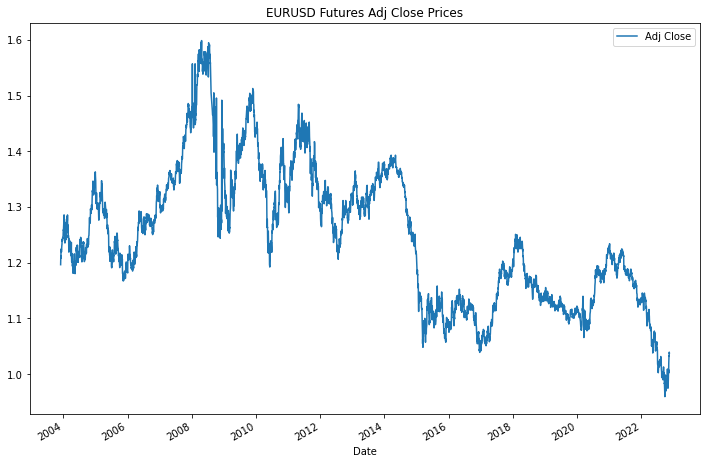

In [4]:
# Plot just the "Adj Close" column from the dataframe:
df_plot=df['Adj Close'].plot(title = f"{ticker} Futures Adj Close Prices",figsize=(12,8),legend=True)
df_fig = df_plot.get_figure()
# df_fig.savefig("./Images/Future_AdjClose_Prices.png")

# Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the Adj Close price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Adj Close" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(df['Adj Close'])

In [6]:
# Create a dataframe of just the Adj Close price, and add columns for "noise" and "trend" series from above:
df_ticker_futures = df[['Adj Close']].copy()
df_ticker_futures['noise'] = settle_noise
df_ticker_futures['trend'] = settle_trend
df_ticker_futures.head()



,Adj Close,noise,trend
Date,,,
2003-12-01,1.196501,-0.008697,1.205198
2003-12-02,1.208897,0.001034,1.207864
2003-12-03,1.212298,0.001773,1.210524
2003-12-04,1.208094,-0.005081,1.213175
2003-12-05,1.218695,0.002883,1.215811


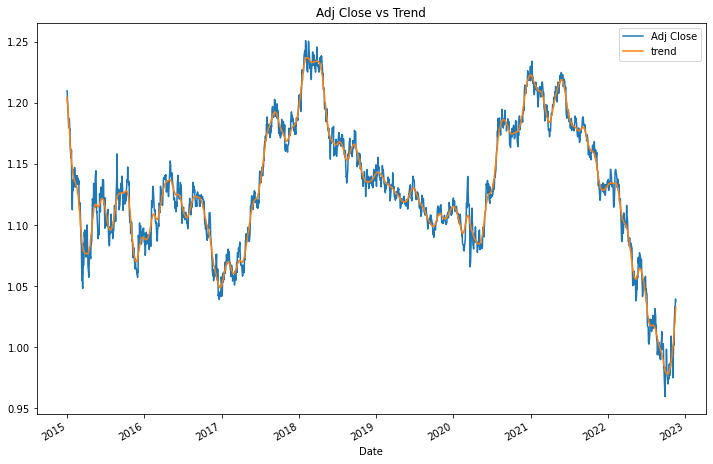

In [7]:
# Plot the Adj Close Price vs. the Trend for 2015 to the present
settle_trend_plot=df_ticker_futures['2015':].plot(y=['Adj Close','trend'],title="Adj Close vs Trend",figsize=(12,8),legend=True)
settle_trend_fig = settle_trend_plot.get_figure()
# settle_trend_fig.savefig("./Images/Adj Close vs Trend.png")



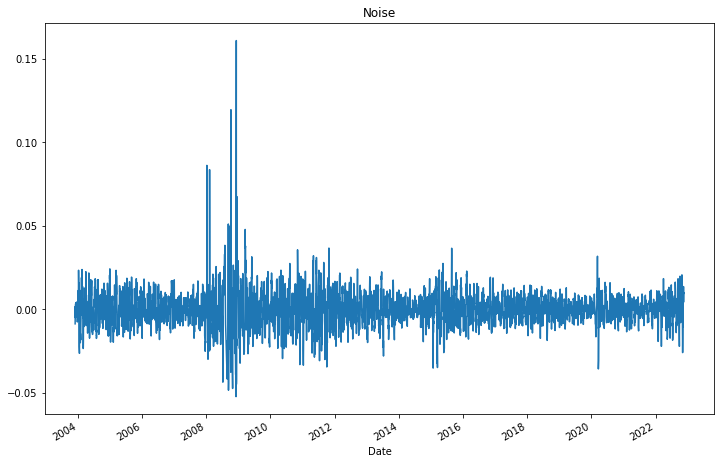

In [8]:
# Plot the Adj Close Noise
noise_plot=df_ticker_futures.plot(y=['noise'],title="Noise",figsize=(12,8),legend=False)
noise_fig = noise_plot.get_figure()
# noise_fig.savefig("./Images/Noise.png")

**Answer**

In the the Adj Close Price vs. the Trend plot, It seems that there are a lot of short term fluctuations that deviate around the trend. The Noise plot gave us a visualization of where the most noise is on this chart. These points can be correllated with volatile periods in the market.

# Forecasting Returns using an ARMA Model

Using futures Adj Close Returns, estimate an ARMA model

    - ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2,1). 
    - Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    - Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)



In [9]:
# Create a series using "Adj Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (df[["Adj Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Adj Close
Date,
2022-11-14,1.337554
2022-11-15,-0.089783
2022-11-16,0.373918
2022-11-17,0.358634
2022-11-18,-0.186767


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from pmdarima.arima import auto_arima
model = sm.tsa.arima.ARIMA(returns.values, order=(1,1,2))
results = model.fit()


# from statsmodels.tsa.arima.model import ARMA
# model = ARMA(returns.values, order=(2,1))

# # Fit the model and assign it to a variable called results
# results = model.fit()



In [11]:
# Output model summary results:
results.summary()
# print(fitted.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4920
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5348.221
Date:                Fri, 18 Nov 2022   AIC                          10704.442
Time:                        08:20:58   BIC                          10730.445
Sample:                             0   HQIC                         10713.563
                               - 4920                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1027      0.042      2.442      0.015       0.020       0.185
ma.L1         -1.3022      0.045    -28.625      0.000      -1.391      -1.213
ma.L2          0.3022      0.043      7.105      0.000       0.219       0.386
sigma2         0.5141      0.009     56.504      0.000       0.496       0.532
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1687568.31
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             2.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        93.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

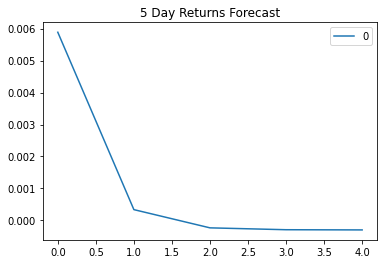

In [12]:
# Plot the 5 Day Returns Forecast

# one-step out-of sample forecast
# forecast = results.forecast(step=5)[0].plot(title="5 Day Returns Forecast")

arma_plot = pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Returns Forecast")
arma_fig = arma_plot.get_figure()
# arma_fig.savefig("./Images/Arma_Five_Days_Returns.png")



# Forecasting the Adj Close Price using an ARIMA Model

    Using the raw Yen Adj Close Price, estimate an ARIMA model.
        Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
        P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
    Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    Construct a 5 day forecast for the Adj Close Price. What does the model forecast will happen to the futures in the near term?



In [13]:
# from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima


# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = sm.tsa.arima.ARIMA(df['Adj Close'], order=(5,1,1))
# Fit the model
results_arima = model.fit()

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Output model summary results:
results_arima.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 4921
Model:                 ARIMA(5, 1, 1)   Log Likelihood               15977.320
Date:                Fri, 18 Nov 2022   AIC                         -31940.639
Time:                        08:20:59   BIC                         -31895.132
Sample:                             0   HQIC                        -31924.677
                               - 4921                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1096      0.002    -72.134      0.000      -0.113      -0.107
ar.L2         -0.0535      0.008     -6.727      0.000      -0.069      -0.038
ar.L3         -0.0037      0.010     -0.361      0.718      -0.024       0.016
ar.L4          0.0033      0.009      0.352      0.725      -0.015       0.022
ar.L5         -0.0012      0.007     -0.160      0.873      -0.015       0.013
ma.L1         -0.1222      0.002    -67.617      0.000      -0.126      -0.119
sigma2      8.847e-05   2.97e-07    297.690      0.000    8.79e-05    8.91e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1776995.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        95.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.79e+16. Standard errors may be unstable.
"""

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


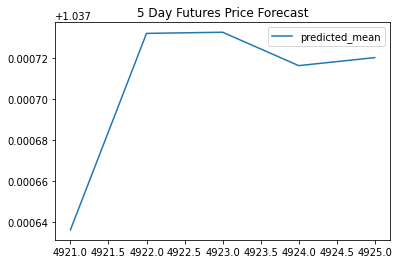

In [15]:
# Plot the 5 Day Price Forecast
arima_plot=pd.DataFrame(results_arima.forecast(steps=5)).plot(title="5 Day Futures Price Forecast")
arima_fig = arima_plot.get_figure()
# arima_fig.savefig("./Images/Arima_Five_Days_Returns.png")



# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term volatility of the futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

Using futures Settle Returns, estimate an GARCH model

    GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
    Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    Plot the 5-day forecast of the volatility.



In [16]:
import arch 

In [17]:
# Estimate a GARCH model:
from arch import arch_model
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_garch = model_garch.fit(disp="off")



In [18]:
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4228.78
Distribution:                  Normal   AIC:                           8465.57
Method:            Maximum Likelihood   BIC:                           8491.57
                                        No. Observations:                 4920
Date:                Fri, Nov 18 2022   Df Residuals:                     4920
Time:                        08:21:00   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.1374e-03  8.640e-04      1.316      0.188 [-5.560e-04,2.831e-03]
alpha[1]       0.0469  1.245e-02      3.768  1.644e-04  [2.251e-02,7.131e-02]
alpha[2]       0.0000  1.477e-02      0.000      1.000 [-2.894e-02,2.894e-02]
beta[1]        0.9531  8.578e-03    111.106      0.000      [  0.936,  0.970]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day



'2022-11-18'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start=last_day, horizon=forecast_horizon, reindex=True)

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2022-11-18,13.328025,13.338774,13.349515,13.360247,13.370971


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()



Date,2022-11-18
h.1,13.328025
h.2,13.338774
h.3,13.349515
h.4,13.360247
h.5,13.370971


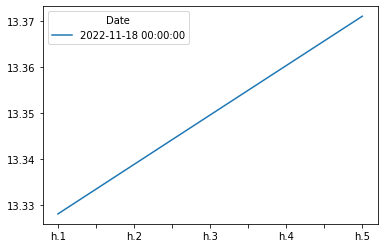

In [23]:
# Plot the final forecast
garch_plot=final.plot()
garch_fig = garch_plot.get_figure()
# garch_fig.savefig("./Images/Garch_forecast.png")

